In [1]:
!pip install xgboost catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# Initialize LabelEncoder here to make it globally accessible
label_encoder = LabelEncoder()


Cross-validation results:
RF: F1 = 0.935 ± 0.003
XGB: F1 = 0.942 ± 0.002
Cat: F1 = 0.941 ± 0.002

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.96      0.87     56000
           1       0.98      0.88      0.93    119341

    accuracy                           0.91    175341
   macro avg       0.88      0.92      0.90    175341
weighted avg       0.92      0.91      0.91    175341


Optimal Threshold: 0.322


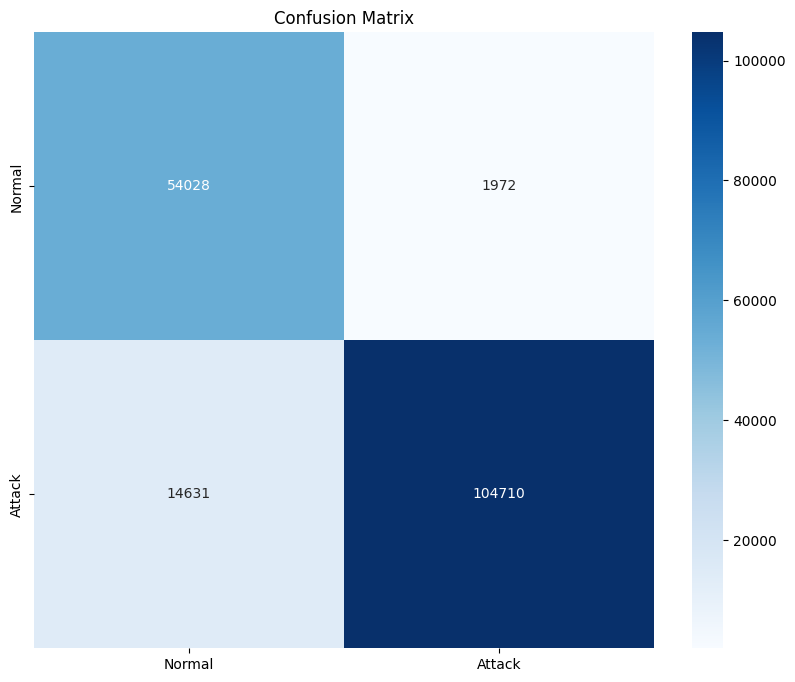


Model artifacts saved successfully


In [13]:
# ==================== DATA LOADING & VALIDATION ====================
def load_and_validate():
    """Load and validate UNSW-NB15 dataset"""
    train = pd.read_csv("UNSW_NB15_training-set.csv")
    test = pd.read_csv("UNSW_NB15_testing-set.csv")

    # Verify no duplicates between train and test
    duplicates = pd.merge(train, test, how='inner')
    if len(duplicates) > 0:
        print(f"Removing {len(duplicates)} duplicate rows")
        train = train.drop_duplicates()
        test = test[~test.isin(train)].dropna()

    return train, test

# ==================== FEATURE ENGINEERING ====================
def engineer_features(df):
    """Create safe features for UNSW-NB15"""
    # Remove obviously problematic features
    df = df.drop(columns=['id', 'attack_cat'], errors='ignore')

    # Create safe temporal features
    safe_features = [
        'dur', 'spkts', 'dpkts', 'sbytes', 'dbytes',
        'rate', 'sttl', 'dttl', 'sload', 'dload',
        'swin', 'dwin', 'stcpb', 'dtcpb', 'tcprtt',
        'synack', 'ackdat', 'response_body_len'
    ]

    # Protocol and service features (categorical)
    cat_features = ['proto', 'service', 'state']

    # Frequency encoding for categoricals
    for col in cat_features:
        freq = df[col].value_counts(normalize=True)
        df[col] = df[col].map(freq)

    return df[safe_features + cat_features]

# ==================== MODEL TRAINING ====================
def train_models(X_train, y_train):
    """Train ensemble with cross-validation"""
    # Base models
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=15,
        class_weight='balanced',
        n_jobs=-1,
        random_state=42
    )

    xgb = XGBClassifier(
        n_estimators=400,
        learning_rate=0.1,
        max_depth=6,
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        eval_metric='logloss',
        random_state=42
    )

    cat = CatBoostClassifier(
        iterations=800,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=3,
        random_seed=42,
        task_type='GPU',
        silent=True
    )

    # Cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    print("Cross-validation results:")
    for name, model in [('RF', rf), ('XGB', xgb), ('Cat', cat)]:
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
        print(f"{name}: F1 = {np.mean(scores):.3f} ± {np.std(scores):.3f}")

    # Train final models
    rf.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    cat.fit(X_train, y_train)

    return rf, xgb, cat

# ==================== EVALUATION ====================
def evaluate_model(model, X_test, y_test):
    """Comprehensive model evaluation"""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    # Optimal threshold finding
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print(f"\nOptimal Threshold: {optimal_threshold:.3f}")

    # Confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['Normal', 'Attack'],
        yticklabels=['Normal', 'Attack']
    )
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    return optimal_threshold

# ==================== MAIN PIPELINE ====================
def main():
    # Load and validate data
    train_df, test_df = load_and_validate()

    # Feature engineering
    X_train = engineer_features(train_df)
    y_train = train_df['label']
    X_test = engineer_features(test_df)
    y_test = test_df['label']

    # Feature scaling
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Feature selection
    selector = SelectKBest(mutual_info_classif, k=15)
    X_train = selector.fit_transform(X_train, y_train)
    X_test = selector.transform(X_test)

    # Train models
    rf, xgb, cat = train_models(X_train, y_train)

    # Create ensemble
    ensemble = VotingClassifier(
        estimators=[('rf', rf), ('xgb', xgb), ('cat', cat)],
        voting='soft',
        weights=[1, 2, 2]
    )
    ensemble.fit(X_train, y_train)

    # Evaluate
    optimal_threshold = evaluate_model(ensemble, X_test, y_test)

    # Save artifacts
    artifacts = {
        'model': ensemble,
        'scaler': scaler,
        'feature_selector': selector,
        'optimal_threshold': optimal_threshold
    }

    joblib.dump(artifacts, "unsw_nb15_detector.pkl")
    print("\nModel artifacts saved successfully")

if __name__ == "__main__":
    main()

In [17]:
import joblib

# Load the saved artifacts
artifacts = joblib.load("unsw_nb15_detector.pkl")

# Extract and save individual components
scaler = artifacts['scaler']
selector = artifacts['feature_selector']

joblib.dump(scaler, "scaler.pkl")
joblib.dump(selector, "feature_selector.pkl")

print("Scaler and feature selector saved separately")

Scaler and feature selector saved separately
